# Demo on Real-life use case

## Import dependencies

In [1]:
from copy import deepcopy

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import trange

from src.imputation import KnnImputer, KnnSampler

## Extract Dataset

In [2]:
df = pd.read_excel("assets/datasets/storm_dataset.xlsx")

In [3]:
input_column = "Brest"
target_column = "Marseille"

## Describe dataset before imputation

In [14]:
def plot_dataset_description(
    df: pd.DataFrame,
    input_col: str,
    target_col: str,
    description: str = "add description",
):
    df = deepcopy(df)
    df["datetime"] = pd.to_datetime(df["datetime"])

    df.sort_values(by="datetime", inplace=True)
    df.set_index("datetime", inplace=True)

    # 5. Build a date range from the earliest to the latest date in your dataset
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")

    # 6. Reindex your dataframe on that full daily range
    df.index = df.index + pd.to_timedelta(
        df.groupby(level=0).cumcount(), unit="s"
    )  # make duplicates unique for reindexing
    df = df.reindex(
        full_range
    )  # Any missing dates become NaN Brest and Marseille  # 8. Plot
    plt.figure(figsize=(15, 6))

    plt.plot(
        df.index, df[input_col], label=f"{input_col} (mm)", color="green", linewidth=2.5
    )
    plt.plot(
        df.index, df[target_col], label=f"{target_col} (mm)", color="red", linewidth=2.5
    )

    # Configure the plot
    plt.xlabel("Date", fontsize=16)
    plt.ylabel("Sea Level (mm)", fontsize=16)
    plt.title(
        f"Sea Level ininput_coland Marseille (2018-2022) - {description}",
        fontsize=16,
    )

    # Format x-axis to show just the year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    # make the axis number bigger
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

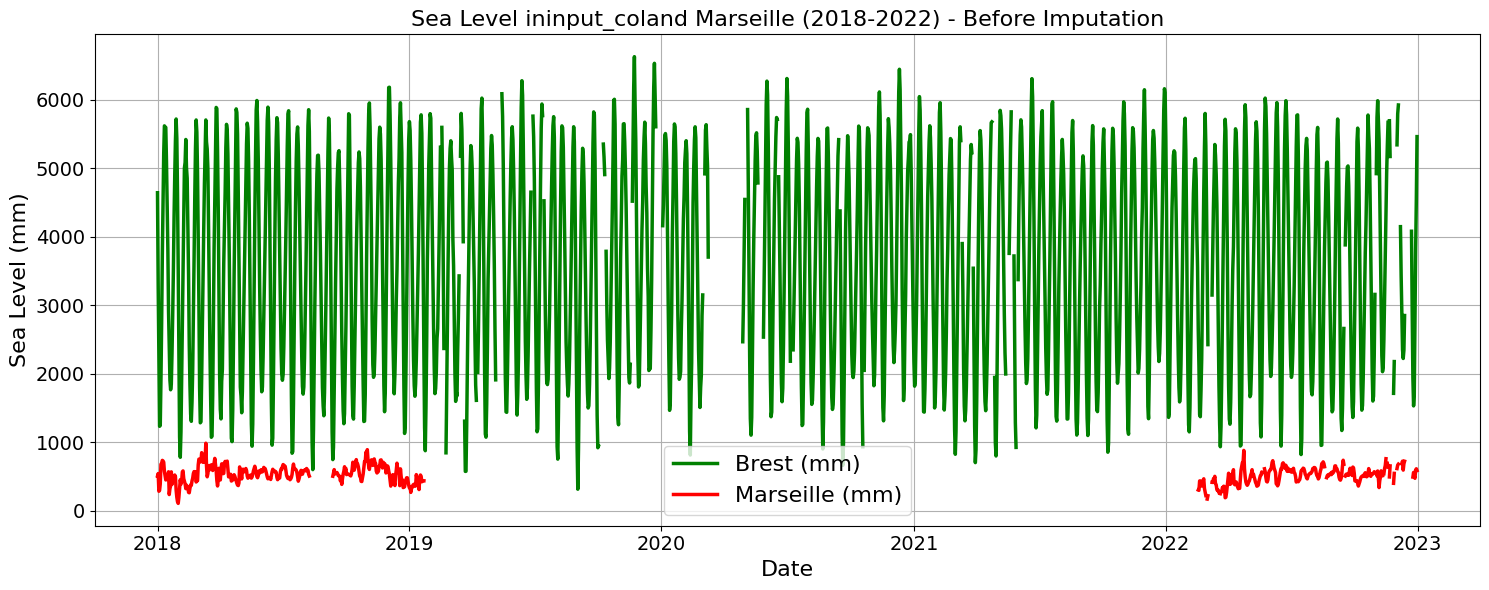

In [5]:
# 4. Replace -32767 with NaN for Brest and Marseille
df[[input_column, target_column]] = df[[input_column, target_column]].replace(
    -32767, np.nan
)
plot_dataset_description(df, input_col=input_column, target_col=target_column)

## Prepare data

In [6]:
from src.data_preparation.data_preparation import (
    ExcelDataPreparator,
    NoAdditionalMissingValues,
)
from src.data_preparation.dataset_description import ExcelDatasetDescriptor

preparator = ExcelDataPreparator(
    ExcelDatasetDescriptor(
        input_column,
        target_column,
        "assets/datasets/storm_dataset.xlsx",
        "Sheet1",
    ),
    NoAdditionalMissingValues(),
    columns_to_keep=["datetime"],
)

prepared_data = preparator.prepare_data()

## Create KnnSampler

In [7]:
imputer = KnnSampler(prepared_data, compute_bounds=False)

## Fit Data

In [8]:
imputer.fit()

## Execute for n iterations

In [9]:
iterations = 2

imputed_datasets: list[pd.DataFrame] = []
for it in (bar := trange(iterations)):
    bar.set_description(f"executing for iteration {it}")
    imputed_datasets.append(imputer.execute())

executing for iteration 1: 100%|██████████| 2/2 [00:34<00:00, 17.03s/it]


## Describe dataset after imputation

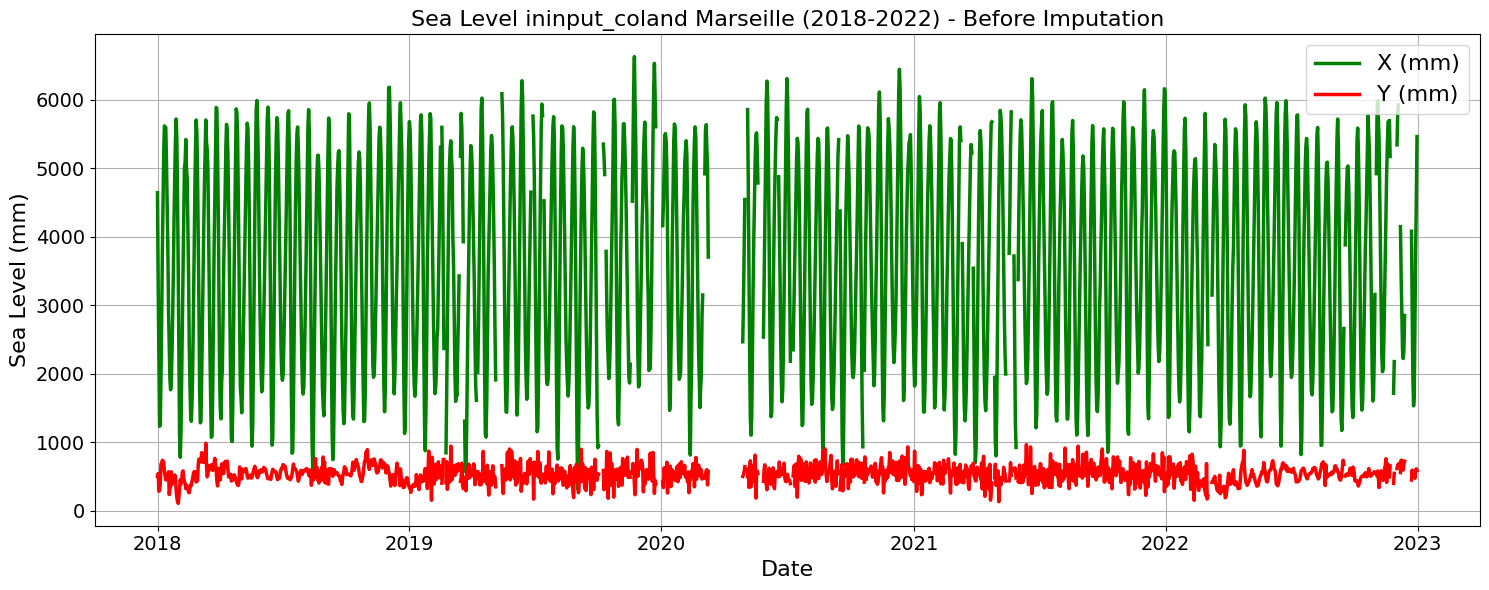

In [13]:
plot_dataset_description(imputed_datasets[0], input_col="X", target_col="Y")

## Create KnnImputer

In [11]:
knn_imputer = KnnImputer(prepared_data)

## Fit and execute

In [12]:
knn_imputer.fit()
knn_imputer_result = knn_imputer.execute()

## Describe KnnImputer results

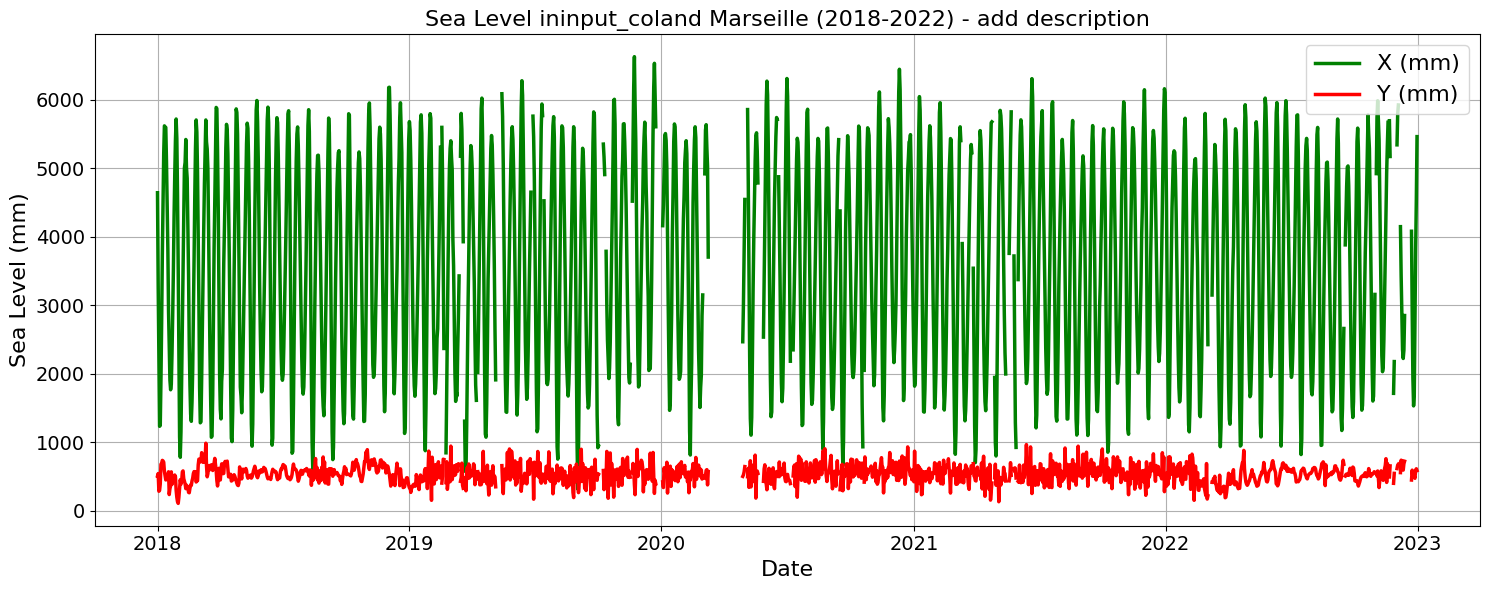

In [15]:
plot_dataset_description(imputed_datasets[0], input_col="X", target_col="Y")

### Calculate the mean and std of the hours across the imputed datasets for October 1-6, 2020


In [14]:
mean_values = []
std_values = []
hours = pd.date_range("2020-10-01", "2020-10-06 23:00", freq="h")

In [15]:
for hour in range(24 * 6):
    marseille_values = []
    for imputed_df in imputed_datasets:
        filtered_df = imputed_df[
            (imputed_df["datetime"] >= "2020-10-01")
            & (imputed_df["datetime"] <= "2020-10-06")
        ]
        marseille_values.append(
            filtered_df[filtered_df.datetime.dt.hour == (hour % 24)].Y.values
        )  # type: ignore
    marseille_values = np.array(marseille_values)
    mean_values.append(marseille_values.mean())
    std_values.append(marseille_values.std())

/var/folders/lv/lwy9qpw55zv8mtn_s230hpzc0000gn/T/ipykernel_88562/702145415.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


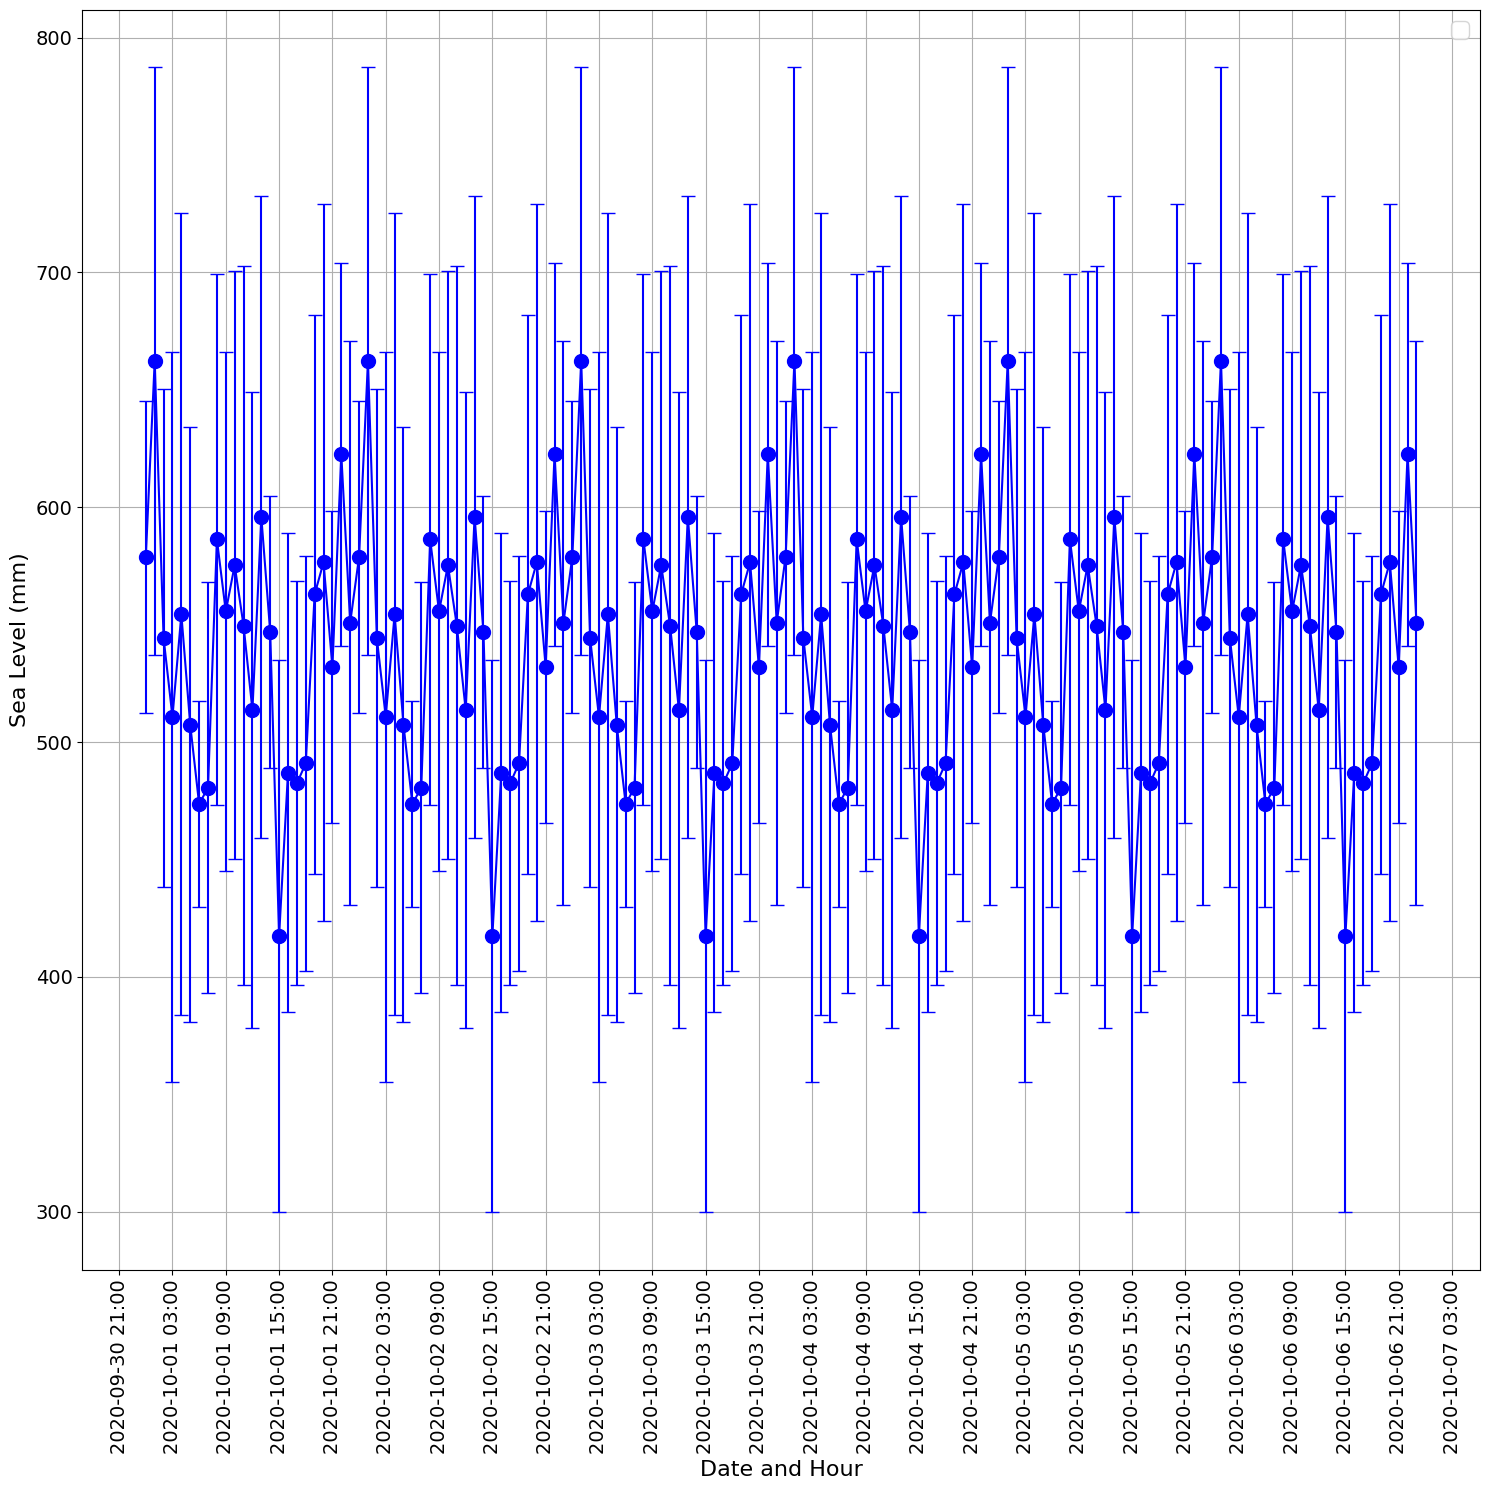

In [16]:
# Plot the mean values with error bars as std for October 1-6, 2020
plt.figure(figsize=(15, 15))
plt.errorbar(
    hours,
    mean_values,
    yerr=std_values,
    fmt="o-",
    color="blue",
    linewidth=1.5,
    markersize=10,
    capsize=5,
)

# Configure the plot
plt.xlabel("Date and Hour", fontsize=16)
plt.ylabel("Sea Level (mm)", fontsize=16)
# plt.title('Mean Sea Level in Marseille (October 1-6, 2020) - Across Imputed Datasets', fontsize=16)

# Format x-axis to show date and hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

# Make the axis numbers bigger
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()